In [3]:
import sys
sys.path.append('../')

from quantumsim import *
import pennylane as qml
from pennylane import numpy as np
import dask


In [1]:
import pennylane as qml
from pennylane import numpy as np
import dask

symbols = ["H", "H"]
coordinates = np.array([0.0, 0.0, -0.6614, 0.0, 0.0, 0.6614], requires_grad=True)
hamil, qubits = qml.qchem.molecular_hamiltonian( symbols= symbols, coordinates= coordinates, charge=0)
coeff, terms = hamil.terms()
terms, coeff = qml.pauli.group_observables(observables=terms, coefficients=coeff, grouping_type='qwc', method='rlf')

dev = qml.device('default.qubit', wires=4)
begin_state = qml.qchem.hf_state(electrons=2, orbitals=qubits)
singles, doubles = qml.qchem.excitations(2, qubits)
singles, doubles = qml.qchem.excitations_to_wires(singles, doubles)

def circuit2(theta, index):
    qml.UCCSD(theta, range(qubits), singles, doubles, begin_state)
    return [qml.expval(u) for u in terms[index]]


node = qml.QNode(circuit2, dev)

def process_group(theta, i):
    result_probs = node(theta=theta, index=i)
    return np.sum( coeff[i]*np.array(result_probs) )

def cost_function(theta):
    results = []
    for i in range(len(terms)):
        results.append( dask.delayed(process_group)(theta, i) )
    num_workers = 1
    result = dask.compute(*results, scheduler="processes", num_workers=num_workers)
    return np.sum( result )

number = len(singles) + len(doubles)
theta = np.random.random( size=number )*(np.pi/180.0)
theta_optimizer = qml.GradientDescentOptimizer(stepsize=0.3)
energy = [cost_function(theta)]
theta_evol = [theta]
for _ in range(40):
    theta.requires_grad = True
    theta = theta_optimizer.step(cost_function, theta)
    energy.append(cost_function(theta))
    theta_evol.append(theta)
    prev_energy = energy[len(energy)-2]
    print(energy[-1])
    conv = np.abs(energy[-1] - prev_energy)
    if conv <= 1e-6:
        break

-1.1224169820319008
-1.1243970335276894
-1.1262235269420677
-1.1278960757015062
-1.129414432384468
-1.1307784886660346
-1.1319882749579817
-1.1330439597468498
-1.1339458486338196
-1.1346943830813792
-1.1352901388728505
-1.1357338242920725
-1.1360262780314365
-1.1361684668376548
-1.1361614829053854
-1.1360065410298625
-1.135704975530402
-1.1352582369573876
-1.1346678885960033
-1.1339356027805376
-1.1330631570335716
-1.132052430044722
-1.1309053975040182
-1.129624127805108
-1.1282107776337338
-1.1266675874569199
-1.1249968769283516
-1.1232010402252945
-1.1212825413322725
-1.1192439092864552
-1.1170877333994846
-1.114816658469973
-1.1124333800006523
-1.1099406394335605
-1.1073412194161552
-1.104637939110784
-1.101833649559156
-1.09893122911304
-1.0959335789415918
-1.0928436186251367


TypeError: 'list' object cannot be interpreted as an integer

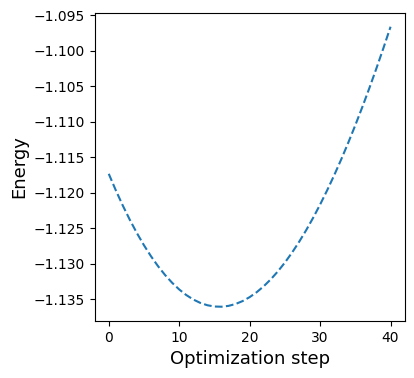

In [12]:
import matplotlib.pyplot as plt
ee = molecular_energies(symbols=symbols, coordinates=coordinates, basis_set="sto-3g")

fig, ax = plt.subplots(1, 1, figsize=(4,4),)
ax.set_xlabel("Optimization step", fontsize=13)
ax.set_ylabel("Energy", fontsize=13)

ax.plot([j for j in range(len(energy))], energy, ls="dashed")
ax.plot([j for j in range( energy ) ], [ee[0] for j in range(energy)], color="black", ls="dashed")

ax.legend(loc="upper right", fontsize='medium',frameon=True, edgecolor='k', ncol=1)
fig.tight_layout()
plt.show()

In [10]:
import pennylane as qml
from pennylane import numpy as np
import dask

symbols = ["H", "H"]
coordinates = np.array([0.0, 0.0, -0.6614, 0.0, 0.0, 0.6614], requires_grad=True)
hamil, qubits = qchem.molecular_hamiltonian( symbols= symbols, coordinates= coordinates, charge=0)
coeff, terms = hamil.terms()
terms, coeff = qml.pauli.group_observables(observables=terms, coefficients=coeff, grouping_type='qwc', method='rlf')

dev = qml.device('default.qubit', wires=4)
begin_state = qml.qchem.hf_state(electrons=2, orbitals=qubits)
singles, doubles = qml.qchem.excitations(2, qubits)
singles, doubles = qml.qchem.excitations_to_wires(singles, doubles)


def circuit2(theta, index):
    qml.UCCSD(theta, range(qubits), singles, doubles, begin_state)
    return [qml.expval(u) for u in terms[index]]

node = qml.QNode(circuit2, dev)

def process_group(theta, i):
    result_probs = node(theta=theta, index=i)
    return np.sum( coeff[i]*np.array(result_probs) )

def cost_function(theta):
    results = []
    for i in range(len(terms)):
        results.append( process_group(theta, i) )
    return np.sum( results )


number = len(singles) + len(doubles)
theta = np.clip(np.random.random( size=number )*(np.pi/180.0), 0, 1e-5)


theta_optimizer = qml.GradientDescentOptimizer(stepsize=0.3)
energy = [cost_function(theta)]
theta_evol = [theta]
for _ in range(100):
    theta.requires_grad = True
    theta = theta_optimizer.step(cost_function, theta)
    energy.append(cost_function(theta))
    theta_evol.append(theta)
    prev_energy = energy[len(energy)-2]
    print(energy[-1])
    conv = np.abs(energy[-1] - prev_energy)
    if conv <= 1e-6:
        break

-1.125745451549811
-1.1304166481171758
-1.1330038506741504
-1.13443310695377
-1.1352215461403654
-1.1356561393802964
-1.1358955858044013
-1.1360274811179079
-1.1361001239663129
-1.1361401299255867
-1.1361621611718928
-1.1361742934912975
-1.1361809745196392
-1.1361846536051277
-1.1361866795836648
-1.1361877952361046
-1.1361884095955104
